# Imports

In [1]:
import pandas as pd
import sklearn.metrics as metrics
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from datetime import datetime, date, timedelta
import talos
import math
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import requests
import io
from time import sleep
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, TimeDistributed, LSTM, Lambda
from tensorflow.keras import regularizers
import tensorflow as tf

Using TensorFlow backend.


# Load data
load hospitalisations and trends for Belgium and France

In [2]:
# topics considered
list_topics = {
    'Fièvre': '/m/0cjf0',
    'Mal de gorge': '/m/0b76bty',
    'Dyspnée': '/m/01cdt5',
    'Agueusie': '/m/05sfr2',
    'Anosmie': '/m/0m7pl',
    'Coronavirus': '/m/01cpyy',
    'Virus': '/m/0g9pc',
    'Température corporelle humaine': '/g/1213j0cz',
    'Épidémie': '/m/0hn9s',
    'Symptôme': '/m/01b_06',
    'Thermomètre': '/m/07mf1',
    'Grippe espagnole': '/m/01c751',
    'Paracétamol': '/m/0lbt3',
    'Respiration': '/m/02gy9_',
    'Toux': '/m/01b_21'
}

geocodes = {
    'FR-A': "Alsace-Champagne-Ardenne-Lorraine",
    'FR-B': "Aquitaine-Limousin-Poitou-Charentes",
    'FR-C': "Auvergne-Rhône-Alpes",
    'FR-P': "Normandie",
    'FR-D': "Bourgogne-Franche-Comté",
    'FR-E': 'Bretagne',
    'FR-F': 'Centre-Val de Loire',
    'FR-G': "Alsace-Champagne-Ardenne-Lorraine",
    'FR-H': 'Corse',
    'FR-I': "Bourgogne-Franche-Comté",
    'FR-Q': "Normandie",
    'FR-J': 'Ile-de-France',
    'FR-K': 'Languedoc-Roussillon-Midi-Pyrénées',
    'FR-L': "Aquitaine-Limousin-Poitou-Charentes",
    'FR-M': "Alsace-Champagne-Ardenne-Lorraine",
    'FR-N': 'Languedoc-Roussillon-Midi-Pyrénées',
    'FR-O': 'Nord-Pas-de-Calais-Picardie',
    'FR-R': 'Pays de la Loire',
    'FR-S': 'Nord-Pas-de-Calais-Picardie',
    'FR-T': "Aquitaine-Limousin-Poitou-Charentes",
    'FR-U': "Provence-Alpes-Côte d'Azur",
    'FR-V': "Auvergne-Rhône-Alpes",
    'BE': "Belgique"
}

In [3]:
date_begin = "2020-02-01"


def create_dataframe_hospi(hospi_france, hospi_belgium, department_france, geo):
    """
    Creates the dataframe containing the number of daily new hospitalizations
    with respect to the date and the localisation (FR and BE)
    """
    departements = pd.read_csv(department_france)
    hospitalisations = pd.read_csv(hospi_france, sep=";")
    data_fr = hospitalisations.join(departements.set_index('departmentCode'), on="dep").groupby(["regionName", "jour"],
                                                                                                as_index=False).agg(
        {"incid_hosp": "sum"})
    data_fr = data_fr.rename(columns={"jour": "DATE", "incid_hosp": "HOSP", "regionName": "LOC"})

    # Belgian data
    data_be = pd.read_csv(hospi_belgium).groupby(["DATE"]).agg({"NEW_IN": "sum"}).reset_index().rename(
        columns={"NEW_IN": "HOSP"})
    data_be["LOC"] = "Belgique"

    # Full data
    full_data = data_fr.append(data_be).set_index(["LOC", "DATE"])

    # find smallest date for each loc
    smallest = {}
    for loc, date_current in full_data.index:
        if loc not in smallest or smallest[loc] > date_current:
            smallest[loc] = date_current

    base_date = datetime.strptime(date_begin, "%Y-%m-%d").date()

    # Add "fake" data (zeroes before the beginning of the crisis) for each loc
    toadd = []
    for loc, sm in smallest.items():
        end = datetime.strptime(sm, "%Y-%m-%d").date()
        cur = base_date

        while cur != end:
            toadd.append([cur.strftime("%Y-%m-%d"), loc, 0])
            cur += timedelta(days=1)

    full_data = pd.DataFrame(toadd, columns=["DATE", "LOC", "HOSP"]).append(full_data.reset_index()).set_index(
        ["LOC", "DATE"])
    data_dic = {}
    for k, v in geo.items():
        data_dic[k] = full_data.iloc[full_data.index.get_level_values('LOC') == v]
    return data_dic


def create_df_trends(url_trends, geo):
    """
    return dic of {geo: df} for the trends
    """
    renaming = {v: k for k, v in list_topics.items()}  # change topic_mid to topic_title in the dataframe
    result = {}
    for k, v in geo.items():
        all_trends = []
        for term in list_topics.keys():
            path = f"{url_trends}{k}-{term}.csv"
            encoded_path = requests.get(path).content
            df_trends = pd.read_csv(io.StringIO(encoded_path.decode("utf-8"))).rename(columns={"date": "DATE"})
            df_trends['LOC'] = v
            df_trends.rename(columns=renaming, inplace=True)
            df_trends.set_index(['LOC', 'DATE'], inplace=True)
            all_trends.append(df_trends)
        result[k] = pd.concat(all_trends, axis=1)
    return result

In [4]:
url_trends = "https://raw.githubusercontent.com/gerardmargaux/CovidThesis/master/data/trends/model/"
url_hospi_belgium = "https://raw.githubusercontent.com/gerardmargaux/CovidThesis/master/data/hospi/be-covid-hospi.csv"
url_department_france = "https://raw.githubusercontent.com/gerardmargaux/CovidThesis/master/src/france_departements.csv"
url_hospi_france = "https://raw.githubusercontent.com/gerardmargaux/CovidThesis/master/data/hospi/fr-covid-hospi.csv"
df_trends = create_df_trends(url_trends, geocodes)
df_hospi = create_dataframe_hospi(url_hospi_france, url_hospi_belgium, url_department_france, geocodes)
merged_df = {k: pd.merge(df_hospi[k], df_trends[k], left_index=True, right_index=True) for k,v in geocodes.items()}
merged_df

{'FR-A':                                               HOSP  Fièvre  Mal de gorge  \
 LOC                               DATE                                     
 Alsace-Champagne-Ardenne-Lorraine 2020-03-01     0      55            59   
                                   2020-03-02     0      25             0   
                                   2020-03-03     0      34            55   
                                   2020-03-04     0      22            19   
                                   2020-03-05     0      35            28   
 ...                                            ...     ...           ...   
                                   2020-10-16    32      20            22   
                                   2020-10-17    39      11             0   
                                   2020-10-18    25      22            46   
                                   2020-10-19    45      30            21   
                                   2020-10-20   127      29         

# Preprocess data
## Normalization
All data is normalized between [-1,1]
No rolling average is done as we want to be able to use the latest data possible

In [5]:
scaler = MinMaxScaler(feature_range=(-1, 1))
#scaled = scaler.fit_transform(merged_df.values)
#merged_df = pd.DataFrame(scaled, columns=merged_df.columns, index=merged_df.index)
#merged_df
for k in geocodes.keys():
    merged_df[k] = pd.DataFrame(scaler.fit_transform(merged_df[k].values), columns=merged_df[k].columns, index=merged_df[k].index)
merged_df

{'FR-A':                                                   HOSP  Fièvre  Mal de gorge  \
 LOC                               DATE                                         
 Alsace-Champagne-Ardenne-Lorraine 2020-03-01 -1.000000    0.10          0.18   
                                   2020-03-02 -1.000000   -0.50         -1.00   
                                   2020-03-03 -1.000000   -0.32          0.10   
                                   2020-03-04 -1.000000   -0.56         -0.62   
                                   2020-03-05 -1.000000   -0.30         -0.44   
 ...                                                ...     ...           ...   
                                   2020-10-16 -0.908178   -0.60         -0.56   
                                   2020-10-17 -0.888092   -0.78         -1.00   
                                   2020-10-18 -0.928264   -0.56         -0.08   
                                   2020-10-19 -0.870875   -0.40         -0.58   
                    

## Days used for the forecast
Each forecast is done for `n_forecast` days and uses `n_samples` days before to construct the prediction

In [6]:
n_forecast = 3  # Number of days we want to predict
n_samples = 14  # Number of days used to make the prediction

In [7]:
def timeseries_add_lag(data, lag, dropna=True):
    """
    add lagged values to dataframe
    """
    df = pd.DataFrame(data)
    init_columns = df.columns
    columns = [df.shift(i) for i in range(lag-1, 0, -1)]
    renaming = {}  # rename the columns
    delay = lag-1
    for i in range(lag-1):
        for k in init_columns:
            renaming[k] = f'{k}(t-{delay})'
        columns[i].rename(columns=renaming ,inplace=True)
        delay -= 1
    columns.append(df)
    df = pd.concat(columns, axis=1)
    return df.dropna() if dropna else df

n_features = merged_df['BE'].shape[1]
lagged_df = {}
for k in geocodes.keys():
    lagged_df[k] = timeseries_add_lag(merged_df[k], n_samples)
lagged_df['BE']

HOSP(t-13)  Fièvre(t-13)  Mal de gorge(t-13)  \
LOC      DATE                                                       
Belgique 2020-03-14   -1.000000     -0.419355           -0.541667   
         2020-03-15   -1.000000     -0.440860           -0.520833   
         2020-03-16   -1.000000     -0.462366           -0.541667   
         2020-03-17   -1.000000     -0.548387           -0.416667   
         2020-03-18   -1.000000     -0.462366           -0.687500   
...                         ...           ...                 ...   
         2020-10-16   -0.767886     -0.677419           -0.791667   
         2020-10-17   -0.726550     -0.763441           -0.270833   
         2020-10-18   -0.723370     -0.591398           -0.437500   
         2020-10-19   -0.669316     -0.655914           -0.687500   
         2020-10-20   -0.580286     -0.741935           -0.812500   

                     Dyspnée(t-13)  Agueusie(t-13)  Anosmie(t-13)  \
LOC      DATE                                                       
Belgique 2020-03-14           0.72           -1.00          -1.00   
         2020-03-15           0.14           -1.00          -1.00   
         2020-03-16          -0.08           -1.00          -1.00   
         2020-03-17           0.04           -1.00          -0.84   
         2020-03-18          -0.34           -0.64          -0.84   
...                            ...             ...            ...   
         2020-10-16          -0.70           -1.00          -0.44   
         2020-10-17          -0.72           -1.00          -1.00   
         2020-10-18          -0.74           -0.64          -1.00   
         2020-10-19          -0.48           -0.28          -1.00   
         2020-10-20          -0.60            0.08          -0.76   

                     Coronavirus(t-13)  Virus(t-13)  \
LOC      DATE                                         
Belgique 2020-03-14          -0.548387    -0.142857   
         2020-03-15          -0.505376     0.020408   
         2020-03-16          -0.548387    -0.102041   
         2020-03-17          -0.591398    -0.224490   
         2020-03-18          -0.505376    -0.081633   
...                                ...          ...   
         2020-10-16          -0.956989    -0.938776   
         2020-10-17          -0.956989    -0.979592   
         2020-10-18          -0.913978    -0.959184   
         2020-10-19          -0.870968    -0.959184   
         2020-10-20          -0.849462    -0.938776   

                     Température corporelle humaine(t-13)  Épidémie(t-13)  \
LOC      DATE                                                               
Belgique 2020-03-14                                 -0.78           -0.48   
         2020-03-15                                 -0.82           -0.58   
         2020-03-16                                 -0.60           -0.48   
         2020-03-17                                 -0.80           -0.60   
         2020-03-18                                 -0.42           -0.64   
...                                                   ...             ...   
         2020-10-16                                 -0.68           -0.86   
         2020-10-17                                 -0.78           -0.86   
         2020-10-18                                 -0.44           -0.90   
         2020-10-19                                 -0.80           -0.88   
         2020-10-20                                 -0.80           -0.88   

                     ...  Coronavirus     Virus  \
LOC      DATE        ...                          
Belgique 2020-03-14  ...     0.677419  0.653061   
         2020-03-15  ...     0.827957  0.816327   
         2020-03-16  ...     0.634409  0.632653   
         2020-03-17  ...     0.548387  0.204082   
         2020-03-18  ...     0.354839  0.183673   
...                  ...          ...       ...   
         2020-10-16  ...    -0.612903 -0.877551   
         2020-10-17  ...    -0.806452 -0.938776 

In [8]:
# shape format for LSTM: [nb_samples, timesteps, input_dim]
dataset = {}
for k in geocodes.keys():
    dataset[k] = lagged_df[k].values.reshape(lagged_df[k].shape[0], n_samples, n_features)
dataset['BE'].shape

(221, 14, 16)

We want the targets to be always differents. For instance, if we use 2 days of forecast based on 3 days of data and the days are indexed as integers we want to have:
1. `x: [1,2,3]`, `y: [4,5]`
2. `x: [3,4,5]`, `y: [6,7]`
2. `x: [5,6,7]`, `y: [8,9]`

and so on

In [9]:
# we take all possible dates for y. If not all dates can be taken, the first dates are dropped
first_set = (len(dataset) - 1) % n_forecast
x_set = {}
y_set = {}
for k in geocodes.keys():
    y_set[k] = np.array([ [dataset[k][i+j+1,n_samples-1,0] for j in range(n_forecast)] for i in range(first_set, len(dataset[k])-n_forecast,n_forecast)])
    x_set[k] = np.array([ dataset[k][i] for i in range(first_set, len(dataset[k])-n_forecast,n_forecast)])
    y_set[k] = y_set[k].reshape(len(x_set[k]), n_forecast, 1)
print(f"len(dataset['BE'])= {len(dataset['BE'])}\t first_set = {first_set}\n{len(y_set['BE'])} sets can be used for training or testing for each region")

len(dataset['BE'])= 221	 first_set = 1
73 sets can be used for training or testing for each region


In [10]:
dates = lagged_df['BE'].index.get_level_values(1)
x_dates = [ dates[i] for i in range(first_set, len(dataset['BE'])-n_forecast,n_forecast)]
y_dates = [ [dates[i+j+1] for j in range(n_forecast)] for i in range(first_set, len(dataset['BE'])-n_forecast,n_forecast)]
print(f'y_dates=\n', y_dates)
print(f'x_dates=\n', x_dates)

y_dates=
 [['2020-03-16', '2020-03-17', '2020-03-18'], ['2020-03-19', '2020-03-20', '2020-03-21'], ['2020-03-22', '2020-03-23', '2020-03-24'], ['2020-03-25', '2020-03-26', '2020-03-27'], ['2020-03-28', '2020-03-29', '2020-03-30'], ['2020-03-31', '2020-04-01', '2020-04-02'], ['2020-04-03', '2020-04-04', '2020-04-05'], ['2020-04-06', '2020-04-07', '2020-04-08'], ['2020-04-09', '2020-04-10', '2020-04-11'], ['2020-04-12', '2020-04-13', '2020-04-14'], ['2020-04-15', '2020-04-16', '2020-04-17'], ['2020-04-18', '2020-04-19', '2020-04-20'], ['2020-04-21', '2020-04-22', '2020-04-23'], ['2020-04-24', '2020-04-25', '2020-04-26'], ['2020-04-27', '2020-04-28', '2020-04-29'], ['2020-04-30', '2020-05-01', '2020-05-02'], ['2020-05-03', '2020-05-04', '2020-05-05'], ['2020-05-06', '2020-05-07', '2020-05-08'], ['2020-05-09', '2020-05-10', '2020-05-11'], ['2020-05-12', '2020-05-13', '2020-05-14'], ['2020-05-15', '2020-05-16', '2020-05-17'], ['2020-05-18', '2020-05-19', '2020-05-20'], ['2020-05-21', '2020-

## Split into train - test set

In [11]:
train_ratio = 0.50
valid_ratio = 0.25
test_ratio = 1.0 - train_ratio - valid_ratio - 1/len(geocodes)

#date training = 2020-09-30

# rescale for sum to be equal to 1
previous_sum = train_ratio + valid_ratio + test_ratio
train_ratio /= previous_sum
valid_ratio /= previous_sum
test_ratio /= previous_sum

all_locs = list(geocodes.keys())
force_test = 'BE'  # forced to be placed in test set
all_locs.remove(force_test)
np.random.shuffle(all_locs)
length = len(all_locs)
train_len = math.ceil(length * train_ratio)
valid_len = math.ceil(length * valid_ratio)

train_datapoints = {loc: (x_set[loc], y_set[loc]) for loc in all_locs[0:train_len]}
valid_datapoints = {loc: (x_set[loc], y_set[loc]) for loc in all_locs[train_len:train_len + valid_len]}
test_datapoints = {loc: (x_set[loc], y_set[loc]) for loc in all_locs[train_len + valid_len:]}
test_datapoints[force_test] = (x_set[force_test], y_set[force_test])


In [12]:
def train_generator():
    while True:
        for loc in train_datapoints:
            yield train_datapoints[loc]

def validation_generator():
    while True:
        for loc in valid_datapoints:
            yield valid_datapoints[loc]

# Toy model

In [13]:
model = Sequential()
model.add(LSTM(32, input_shape=(n_samples, n_features), return_sequences=True))
model.add(LSTM(32, input_shape=(n_samples, n_features), return_sequences=False))
model.add(Dense(n_forecast))
print(model.output_shape)

(None, 3)


In [14]:
#history = model.fit(x_train, y_train, epochs=400, verbose=1, shuffle=False)
model.compile(loss="mse", optimizer='adam')
history = model.fit(train_generator(), steps_per_epoch=len(train_datapoints), epochs=400, verbose=1, shuffle=False, 
          validation_data=validation_generator(),
          validation_steps=len(valid_datapoints))

Epoch 1/400
12/12 [==============================] - 1s 45ms/step - loss: 0.3669 - val_loss: 0.1000
Epoch 2/400
12/12 [==============================] - 0s 9ms/step - loss: 0.1266 - val_loss: 0.1005
Epoch 3/400
12/12 [==============================] - 0s 9ms/step - loss: 0.1053 - val_loss: 0.0942
Epoch 4/400
12/12 [==============================] - 0s 9ms/step - loss: 0.0896 - val_loss: 0.0752
Epoch 5/400
12/12 [==============================] - 0s 9ms/step - loss: 0.0720 - val_loss: 0.0623
Epoch 6/400
12/12 [==============================] - 0s 9ms/step - loss: 0.0598 - val_loss: 0.0548
Epoch 7/400
12/12 [==============================] - 0s 9ms/step - loss: 0.0540 - val_loss: 0.0505
Epoch 8/400
12/12 [==============================] - 0s 9ms/step - loss: 0.0494 - val_loss: 0.0457
Epoch 9/400
12/12 [==============================] - 0s 10ms/step - loss: 0.0446 - val_loss: 0.0420
Epoch 10/400
12/12 [==============================] - 0s 11ms/step - loss: 0.0400 - val_loss: 0.0392
Epoch 

12/12 [==============================] - 0s 11ms/step - loss: 0.0150 - val_loss: 0.0320
Epoch 83/400
12/12 [==============================] - 0s 11ms/step - loss: 0.0149 - val_loss: 0.0320
Epoch 84/400
12/12 [==============================] - 0s 11ms/step - loss: 0.0148 - val_loss: 0.0320
Epoch 85/400
12/12 [==============================] - 0s 12ms/step - loss: 0.0146 - val_loss: 0.0321
Epoch 86/400
12/12 [==============================] - 0s 13ms/step - loss: 0.0145 - val_loss: 0.0321
Epoch 87/400
12/12 [==============================] - 0s 12ms/step - loss: 0.0144 - val_loss: 0.0322
Epoch 88/400
12/12 [==============================] - 0s 15ms/step - loss: 0.0142 - val_loss: 0.0322
Epoch 89/400
12/12 [==============================] - 0s 11ms/step - loss: 0.0141 - val_loss: 0.0322
Epoch 90/400
12/12 [==============================] - 0s 14ms/step - loss: 0.0140 - val_loss: 0.0323
Epoch 91/400
12/12 [==============================] - 0s 11ms/step - loss: 0.0138 - val_loss: 0.0323
Epo

Epoch 163/400
12/12 [==============================] - 0s 10ms/step - loss: 0.0084 - val_loss: 0.0313
Epoch 164/400
12/12 [==============================] - 0s 10ms/step - loss: 0.0084 - val_loss: 0.0324
Epoch 165/400
12/12 [==============================] - 0s 10ms/step - loss: 0.0087 - val_loss: 0.0346
Epoch 166/400
12/12 [==============================] - 0s 9ms/step - loss: 0.0089 - val_loss: 0.0317
Epoch 167/400
12/12 [==============================] - 0s 10ms/step - loss: 0.0087 - val_loss: 0.0337
Epoch 168/400
12/12 [==============================] - 0s 10ms/step - loss: 0.0086 - val_loss: 0.0343
Epoch 169/400
12/12 [==============================] - 0s 10ms/step - loss: 0.0084 - val_loss: 0.0321
Epoch 170/400
12/12 [==============================] - 0s 11ms/step - loss: 0.0083 - val_loss: 0.0328
Epoch 171/400
12/12 [==============================] - 0s 11ms/step - loss: 0.0083 - val_loss: 0.0335
Epoch 172/400
12/12 [==============================] - 0s 11ms/step - loss: 0.0082 

12/12 [==============================] - 0s 10ms/step - loss: 0.0062 - val_loss: 0.0355
Epoch 244/400
12/12 [==============================] - 0s 10ms/step - loss: 0.0062 - val_loss: 0.0364
Epoch 245/400
12/12 [==============================] - 0s 10ms/step - loss: 0.0063 - val_loss: 0.0360
Epoch 246/400
12/12 [==============================] - 0s 10ms/step - loss: 0.0062 - val_loss: 0.0357
Epoch 247/400
12/12 [==============================] - 0s 11ms/step - loss: 0.0061 - val_loss: 0.0358
Epoch 248/400
12/12 [==============================] - 0s 11ms/step - loss: 0.0060 - val_loss: 0.0360
Epoch 249/400
12/12 [==============================] - 0s 10ms/step - loss: 0.0061 - val_loss: 0.0370
Epoch 250/400
12/12 [==============================] - 0s 10ms/step - loss: 0.0064 - val_loss: 0.0386
Epoch 251/400
12/12 [==============================] - 0s 10ms/step - loss: 0.0073 - val_loss: 0.0383
Epoch 252/400
12/12 [==============================] - 0s 9ms/step - loss: 0.0076 - val_loss: 0.

12/12 [==============================] - 0s 11ms/step - loss: 0.0053 - val_loss: 0.0379
Epoch 324/400
12/12 [==============================] - 0s 10ms/step - loss: 0.0054 - val_loss: 0.0381
Epoch 325/400
12/12 [==============================] - 0s 10ms/step - loss: 0.0051 - val_loss: 0.0363
Epoch 326/400
12/12 [==============================] - 0s 10ms/step - loss: 0.0050 - val_loss: 0.0363
Epoch 327/400
12/12 [==============================] - 0s 10ms/step - loss: 0.0049 - val_loss: 0.0382
Epoch 328/400
12/12 [==============================] - 0s 10ms/step - loss: 0.0048 - val_loss: 0.0378
Epoch 329/400
12/12 [==============================] - 0s 10ms/step - loss: 0.0050 - val_loss: 0.0362
Epoch 330/400
12/12 [==============================] - 0s 10ms/step - loss: 0.0052 - val_loss: 0.0358
Epoch 331/400
12/12 [==============================] - 0s 11ms/step - loss: 0.0059 - val_loss: 0.0363
Epoch 332/400
12/12 [==============================] - 0s 11ms/step - loss: 0.0058 - val_loss: 0

TRAINING FR-K


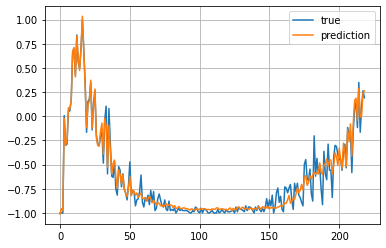

TRAINING FR-A


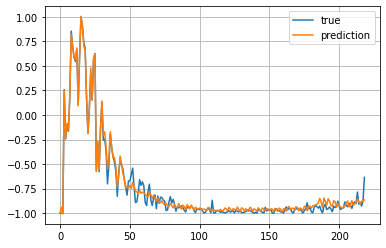

TRAINING FR-V


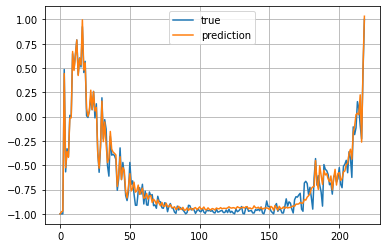

TRAINING FR-F


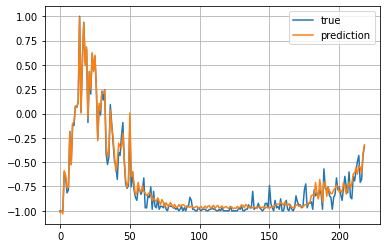

TRAINING FR-B


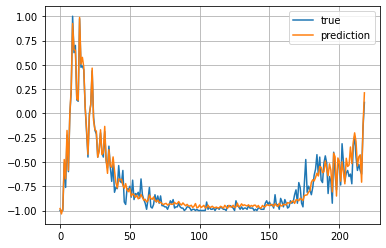

TRAINING FR-J


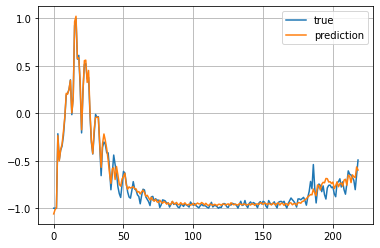

TRAINING FR-S


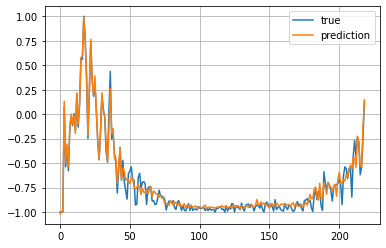

TRAINING FR-P


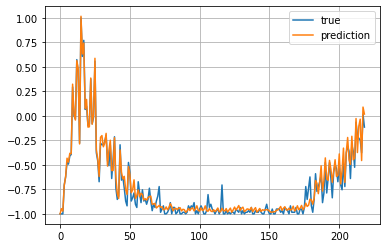

TRAINING FR-Q


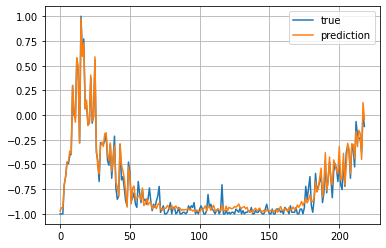

TRAINING FR-C


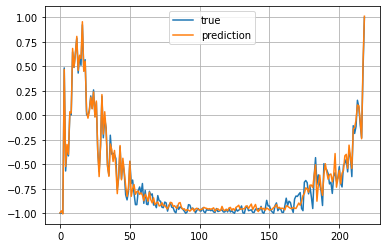

TRAINING FR-M


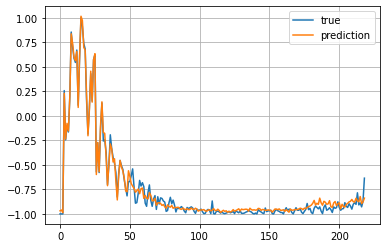

TRAINING FR-G


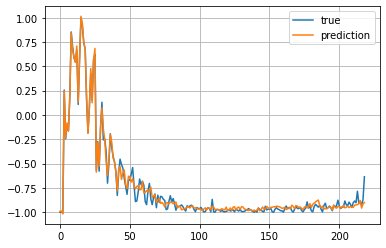

VALIDATION FR-N


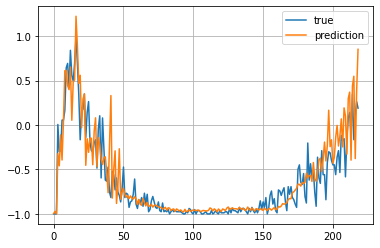

VALIDATION FR-O


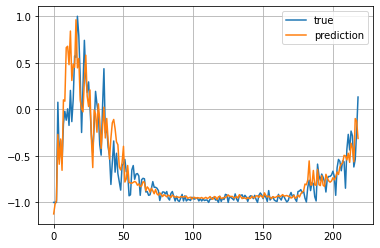

VALIDATION FR-I


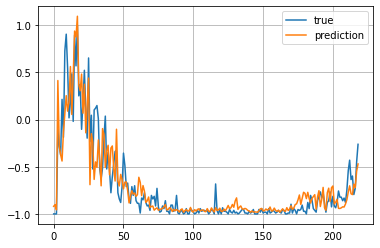

VALIDATION FR-L


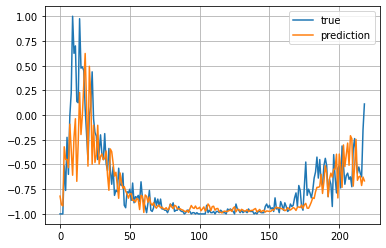

VALIDATION FR-H


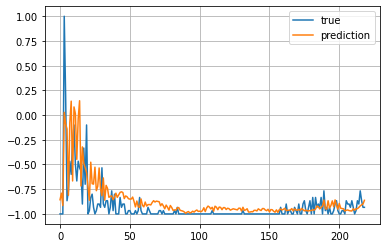

VALIDATION FR-E


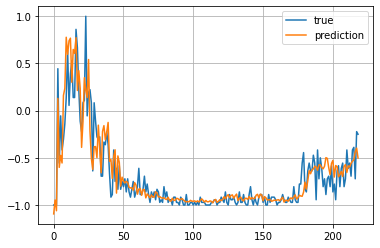

TEST FR-D


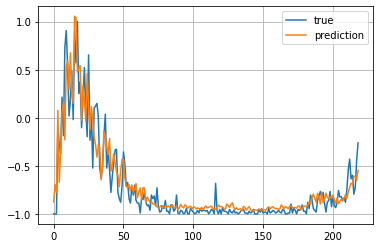

TEST FR-T


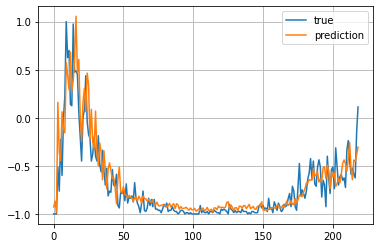

TEST FR-R


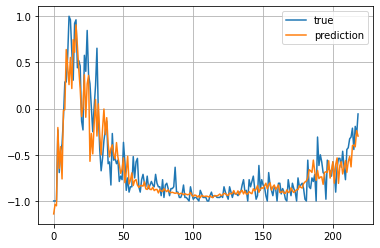

TEST FR-U


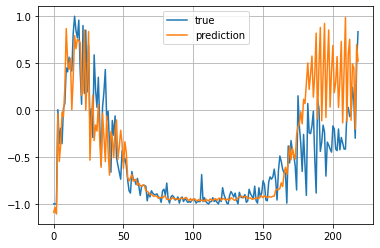

TEST BE


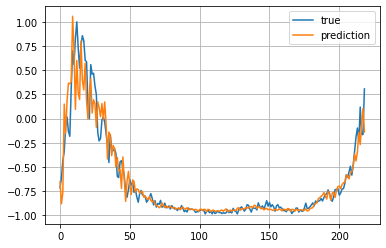

In [15]:
for loc in train_datapoints:
    print("TRAINING", loc)
    x, y = train_datapoints[loc]
    yp = model.predict(x)

    plt.plot(y.reshape(-1), label='true')
    plt.plot(yp.reshape(-1), label='prediction')
    plt.legend()
    plt.grid()
    plt.show()
    
for loc in valid_datapoints:
    print("VALIDATION", loc)
    x, y = valid_datapoints[loc]
    yp = model.predict(x)

    plt.plot(y.reshape(-1), label='true')
    plt.plot(yp.reshape(-1), label='prediction')
    plt.legend()
    plt.grid()
    plt.show()
    
for loc in test_datapoints:
    print("TEST", loc)
    x, y = test_datapoints[loc]
    yp = model.predict(x)

    plt.plot(y.reshape(-1), label='true')
    plt.plot(yp.reshape(-1), label='prediction')
    plt.legend()
    plt.grid()
    plt.show()

# Let's use the validation set

In [22]:
import talos

def run_model(_, _2, _3, _4, p):
    model = Sequential()
    model.add(LSTM(p["n_lstm_node_first"], input_shape=(n_samples, n_features), 
              kernel_regularizer=p['reg'](p['regw']), return_sequences=(p["n_lstm_node_second"] != 0)))
    if p["n_lstm_node_second"] != 0:
        model.add(LSTM(p["n_lstm_node_second"], return_sequences=False, kernel_regularizer=p['reg'](p['regw'])))
    for _ in range(p["n_layers_after"]):
        model.add(Dense(p["n_node_hidden_layers"], kernel_regularizer=p['reg'](p['regw']), 
                        activation=p['activation']))
    model.add(Dense(n_forecast, kernel_regularizer=p['reg'](p['regw'])))

    model.compile(loss=p["losses"], optimizer=p["optimizer"], metrics=['mae', 'mse'])
    history = model.fit(train_generator(), steps_per_epoch=len(train_datapoints), epochs=p["epochs"], verbose=0, shuffle=False, 
              validation_data=validation_generator(),
              validation_steps=len(valid_datapoints))
    
    return history, model

p = {'activation':['relu', 'elu', 'sigmoid'],
     'n_layers_after': [0, 1, 2],
     'n_node_hidden_layers': [10, 30, 50],
     'n_lstm_node_first': [10, 20, 30],
     'n_lstm_node_second': [0, 10, 20, 30],
     'reg': [lambda x: regularizers.l2(l=x), lambda x: regularizers.l1(l=x), lambda x: None],
     'regw': [1e-4, 5e-4, 1e-3],
     'optimizer': ['Adam', 'sgd'],
     'losses': ['mae', 'mse'],
     'epochs': [300, 500],
}
scan_object = talos.Scan(
    x=[],
    y=[],
    x_val=[],
    y_val=[],
    params=p,
    model=run_model,
    experiment_name='trends1', 
    fraction_limit=0.01
)

100%|██████████| 233/233 [3:05:00<00:00, 47.64s/it]  


In [23]:
# compute MSE and MAE
analyze_object = talos.Analyze(scan_object)
print("MAE", analyze_object.low('mae'))
print("MSE", analyze_object.low('mse'))
print("VAL MAE", analyze_object.low('val_mae'))
print("VAL MSE", analyze_object.low('val_mse'))
analyze_object.table('val_mse', exclude=[], ascending=True)

MAE 0.04365124925971031
MSE 0.00387284392490983
VAL MAE 0.0952138602733612
VAL MSE 0.025303218513727188


,val_loss,mse,loss,n_lstm_node_first,val_mae,round_epochs,mae,n_layers_after,reg,n_node_hidden_layers,epochs,duration,regw,optimizer,end,activation,val_mse,start,losses,n_lstm_node_second
15,0.107450,0.020716,0.097612,10,0.095214,300,0.085362,0,<function <lambda> at 0x7f34942a9b80>,30,300,36.311977,0.0010,Adam,10/25/20-082407,elu,0.025303,10/25/20-082330,mae,30
179,0.101220,0.014965,0.075215,30,0.097933,300,0.071932,0,<function <lambda> at 0x7f34942a9b80>,30,300,23.707988,0.0001,Adam,10/25/20-103416,elu,0.026033,10/25/20-103352,mae,0
129,0.109524,0.020348,0.095728,20,0.098905,300,0.085103,0,<function <lambda> at 0x7f34942a9b80>,10,300,23.119222,0.0010,Adam,10/25/20-095542,relu,0.026304,10/25/20-095518,mae,0
221,0.032407,0.012762,0.018632,30,0.096049,500,0.075609,0,<function <lambda> at 0x7f34942a9af0>,10,500,41.293876,0.0005,Adam,10/25/20-110721,relu,0.026538,10/25/20-110640,mse,0
32,0.127064,0.015293,0.098125,20,0.103649,300,0.074693,2,<function <lambda> at 0x7f34942a9af0>,50,300,21.042731,0.0001,Adam,10/25/20-083531,relu,0.027566,10/25/20-083510,mae,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48,0.234972,0.192090,0.256724,30,0.234972,300,0.256724,2,<function <lambda> at 0x7f3494277280>,50,300,42.694274,0.0005,sgd,10/25/20-084821,sigmoid,0.178017,10/25/20-084738,mae,30
174,0.238222,0.198124,0.261985,10,0.238222,300,0.261985,2,<function <lambda> at 0x7f3494277280>,30,300,35.145667,0.0001,sgd,10/25/20-103144,sigmoid,0.183553,10/25/20-103109,mae,20
4,0.255519,0.205200,0.277901,20,0.243756,300,0.266138,2,<function <lambda> at 0x7f34942a9b80>,30,300,34.836030,0.0001,sgd,10/25/20-081548,sigmoid,0.191639,10/25/20-081513,mae,20
79,0.244031,0.206394,0.266567,20,0.244031,500,0.266567,2,<function <lambda> at 0x7f3494277280>,50,500,72.364700,0.0010,sgd,10/25/20-091452,sigmoid,0.193096,10/25/20-091340,mae,30


# Base line models
## MultiStepLastBaseline
This model repeats the last value of hospitalisations `n_forecast` time

In [16]:
class MultiStepLastBaseline(tf.keras.Model):
    """
    repeat the last hospitalisations given as input n_forecast time
    """
    def call(self, inputs):
        a = inputs[:, -1:, :1]  # hospitalisations of the last days
        return tf.tile(
            a,
            [1, n_forecast, 1]   # repeat hospitalisations n_forecast time
        )

BaselineModel = MultiStepLastBaseline()
BaselineModel.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

## Linear regression
linear regression of the last `n_sample` days used to predict the next `n_forecast` days

In [17]:
class LinearRegressionHospi(tf.keras.Model):
    """
    repeat the last hospitalisations given as input n_forecast time
    """
    def predict(self, inputs):
        y = inputs[:, :, 0]  # hospitalisations of the last days
        length = len(inputs)
        x = np.arange(n_samples).reshape(-1,1)  # dates of the hospitalisations
        result = np.zeros((length, n_forecast))
        for i in range(length):
            regr = LinearRegression().fit(x,y[i])  # linear regression of (days, hospi)
            result[i] = regr.predict(np.arange(n_samples, n_samples+n_forecast).reshape(-1,1))
        return result
        

## 1 fully connected layer (Dense model)

In [18]:
DenseModel = Sequential()
DenseModel.add(Lambda(lambda x: x[:,:,0]))  # select only the hospitalisations of the previous days
DenseModel.add(Dense(n_forecast))   # predict the next hospitalisations based on the previous ones
DenseModel.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

In [19]:
LinearModel_history = DenseModel.fit(train_generator(), steps_per_epoch=len(train_datapoints), epochs=400, verbose=1, shuffle=False, 
          validation_data=validation_generator(),
          validation_steps=len(valid_datapoints))

Epoch 1/400
12/12 [==============================] - 0s 19ms/step - loss: 1.6598 - mean_absolute_error: 1.0190 - val_loss: 1.4813 - val_mean_absolute_error: 0.9628
Epoch 2/400
12/12 [==============================] - 0s 3ms/step - loss: 1.3358 - mean_absolute_error: 0.9116 - val_loss: 1.2221 - val_mean_absolute_error: 0.8719
Epoch 3/400
12/12 [==============================] - 0s 3ms/step - loss: 1.1065 - mean_absolute_error: 0.8260 - val_loss: 1.0105 - val_mean_absolute_error: 0.7886
Epoch 4/400
12/12 [==============================] - 0s 3ms/step - loss: 0.9143 - mean_absolute_error: 0.7459 - val_loss: 0.8301 - val_mean_absolute_error: 0.7087
Epoch 5/400
12/12 [==============================] - 0s 3ms/step - loss: 0.7503 - mean_absolute_error: 0.6690 - val_loss: 0.6767 - val_mean_absolute_error: 0.6324
Epoch 6/400
12/12 [==============================] - 0s 3ms/step - loss: 0.6114 - mean_absolute_error: 0.5959 - val_loss: 0.5480 - val_mean_absolute_error: 0.5610
Epoch 7/400
12/12 [==

12/12 [==============================] - 0s 2ms/step - loss: 0.0434 - mean_absolute_error: 0.1247 - val_loss: 0.0502 - val_mean_absolute_error: 0.1297
Epoch 52/400
12/12 [==============================] - 0s 2ms/step - loss: 0.0430 - mean_absolute_error: 0.1241 - val_loss: 0.0498 - val_mean_absolute_error: 0.1292
Epoch 53/400
12/12 [==============================] - 0s 2ms/step - loss: 0.0426 - mean_absolute_error: 0.1235 - val_loss: 0.0494 - val_mean_absolute_error: 0.1286
Epoch 54/400
12/12 [==============================] - 0s 2ms/step - loss: 0.0422 - mean_absolute_error: 0.1228 - val_loss: 0.0490 - val_mean_absolute_error: 0.1281
Epoch 55/400
12/12 [==============================] - 0s 2ms/step - loss: 0.0419 - mean_absolute_error: 0.1222 - val_loss: 0.0487 - val_mean_absolute_error: 0.1275
Epoch 56/400
12/12 [==============================] - 0s 2ms/step - loss: 0.0415 - mean_absolute_error: 0.1216 - val_loss: 0.0483 - val_mean_absolute_error: 0.1270
Epoch 57/400
12/12 [=========

12/12 [==============================] - 0s 2ms/step - loss: 0.0330 - mean_absolute_error: 0.1071 - val_loss: 0.0406 - val_mean_absolute_error: 0.1154
Epoch 102/400
12/12 [==============================] - 0s 2ms/step - loss: 0.0330 - mean_absolute_error: 0.1069 - val_loss: 0.0405 - val_mean_absolute_error: 0.1152
Epoch 103/400
12/12 [==============================] - 0s 2ms/step - loss: 0.0329 - mean_absolute_error: 0.1067 - val_loss: 0.0405 - val_mean_absolute_error: 0.1151
Epoch 104/400
12/12 [==============================] - 0s 2ms/step - loss: 0.0328 - mean_absolute_error: 0.1066 - val_loss: 0.0404 - val_mean_absolute_error: 0.1150
Epoch 105/400
12/12 [==============================] - 0s 2ms/step - loss: 0.0327 - mean_absolute_error: 0.1064 - val_loss: 0.0403 - val_mean_absolute_error: 0.1149
Epoch 106/400
12/12 [==============================] - 0s 2ms/step - loss: 0.0326 - mean_absolute_error: 0.1063 - val_loss: 0.0403 - val_mean_absolute_error: 0.1148
Epoch 107/400
12/12 [===

Epoch 151/400
12/12 [==============================] - 0s 2ms/step - loss: 0.0307 - mean_absolute_error: 0.1025 - val_loss: 0.0389 - val_mean_absolute_error: 0.1121
Epoch 152/400
12/12 [==============================] - 0s 2ms/step - loss: 0.0307 - mean_absolute_error: 0.1025 - val_loss: 0.0388 - val_mean_absolute_error: 0.1121
Epoch 153/400
12/12 [==============================] - 0s 2ms/step - loss: 0.0306 - mean_absolute_error: 0.1024 - val_loss: 0.0388 - val_mean_absolute_error: 0.1121
Epoch 154/400
12/12 [==============================] - 0s 2ms/step - loss: 0.0306 - mean_absolute_error: 0.1024 - val_loss: 0.0388 - val_mean_absolute_error: 0.1121
Epoch 155/400
12/12 [==============================] - 0s 2ms/step - loss: 0.0306 - mean_absolute_error: 0.1024 - val_loss: 0.0388 - val_mean_absolute_error: 0.1120
Epoch 156/400
12/12 [==============================] - 0s 2ms/step - loss: 0.0306 - mean_absolute_error: 0.1023 - val_loss: 0.0388 - val_mean_absolute_error: 0.1120
Epoch 157/

Epoch 201/400
12/12 [==============================] - 0s 3ms/step - loss: 0.0300 - mean_absolute_error: 0.1013 - val_loss: 0.0386 - val_mean_absolute_error: 0.1115
Epoch 202/400
12/12 [==============================] - 0s 2ms/step - loss: 0.0300 - mean_absolute_error: 0.1013 - val_loss: 0.0386 - val_mean_absolute_error: 0.1115
Epoch 203/400
12/12 [==============================] - 0s 2ms/step - loss: 0.0300 - mean_absolute_error: 0.1012 - val_loss: 0.0386 - val_mean_absolute_error: 0.1115
Epoch 204/400
12/12 [==============================] - 0s 2ms/step - loss: 0.0300 - mean_absolute_error: 0.1012 - val_loss: 0.0386 - val_mean_absolute_error: 0.1115
Epoch 205/400
12/12 [==============================] - 0s 2ms/step - loss: 0.0300 - mean_absolute_error: 0.1012 - val_loss: 0.0386 - val_mean_absolute_error: 0.1115
Epoch 206/400
12/12 [==============================] - 0s 2ms/step - loss: 0.0300 - mean_absolute_error: 0.1012 - val_loss: 0.0386 - val_mean_absolute_error: 0.1115
Epoch 207/

Epoch 251/400
12/12 [==============================] - 0s 2ms/step - loss: 0.0298 - mean_absolute_error: 0.1008 - val_loss: 0.0386 - val_mean_absolute_error: 0.1116
Epoch 252/400
12/12 [==============================] - 0s 2ms/step - loss: 0.0298 - mean_absolute_error: 0.1008 - val_loss: 0.0386 - val_mean_absolute_error: 0.1116
Epoch 253/400
12/12 [==============================] - 0s 2ms/step - loss: 0.0298 - mean_absolute_error: 0.1008 - val_loss: 0.0386 - val_mean_absolute_error: 0.1116
Epoch 254/400
12/12 [==============================] - 0s 2ms/step - loss: 0.0298 - mean_absolute_error: 0.1008 - val_loss: 0.0386 - val_mean_absolute_error: 0.1116
Epoch 255/400
12/12 [==============================] - 0s 2ms/step - loss: 0.0298 - mean_absolute_error: 0.1008 - val_loss: 0.0386 - val_mean_absolute_error: 0.1116
Epoch 256/400
12/12 [==============================] - 0s 2ms/step - loss: 0.0298 - mean_absolute_error: 0.1008 - val_loss: 0.0386 - val_mean_absolute_error: 0.1116
Epoch 257/

Epoch 301/400
12/12 [==============================] - 0s 2ms/step - loss: 0.0297 - mean_absolute_error: 0.1007 - val_loss: 0.0387 - val_mean_absolute_error: 0.1116
Epoch 302/400
12/12 [==============================] - 0s 2ms/step - loss: 0.0297 - mean_absolute_error: 0.1006 - val_loss: 0.0387 - val_mean_absolute_error: 0.1116
Epoch 303/400
12/12 [==============================] - 0s 2ms/step - loss: 0.0297 - mean_absolute_error: 0.1006 - val_loss: 0.0387 - val_mean_absolute_error: 0.1116
Epoch 304/400
12/12 [==============================] - 0s 2ms/step - loss: 0.0297 - mean_absolute_error: 0.1006 - val_loss: 0.0387 - val_mean_absolute_error: 0.1116
Epoch 305/400
12/12 [==============================] - 0s 2ms/step - loss: 0.0297 - mean_absolute_error: 0.1006 - val_loss: 0.0387 - val_mean_absolute_error: 0.1116
Epoch 306/400
12/12 [==============================] - 0s 2ms/step - loss: 0.0297 - mean_absolute_error: 0.1006 - val_loss: 0.0387 - val_mean_absolute_error: 0.1116
Epoch 307/

Epoch 351/400
12/12 [==============================] - 0s 2ms/step - loss: 0.0297 - mean_absolute_error: 0.1006 - val_loss: 0.0387 - val_mean_absolute_error: 0.1117
Epoch 352/400
12/12 [==============================] - 0s 2ms/step - loss: 0.0297 - mean_absolute_error: 0.1006 - val_loss: 0.0387 - val_mean_absolute_error: 0.1117
Epoch 353/400
12/12 [==============================] - 0s 2ms/step - loss: 0.0297 - mean_absolute_error: 0.1006 - val_loss: 0.0388 - val_mean_absolute_error: 0.1117
Epoch 354/400
12/12 [==============================] - 0s 2ms/step - loss: 0.0297 - mean_absolute_error: 0.1006 - val_loss: 0.0388 - val_mean_absolute_error: 0.1117
Epoch 355/400
12/12 [==============================] - 0s 2ms/step - loss: 0.0297 - mean_absolute_error: 0.1006 - val_loss: 0.0388 - val_mean_absolute_error: 0.1117
Epoch 356/400
12/12 [==============================] - 0s 2ms/step - loss: 0.0297 - mean_absolute_error: 0.1006 - val_loss: 0.0388 - val_mean_absolute_error: 0.1117
Epoch 357/

# Comparisons of the models

In [41]:
#LSTMModel = scan_object.best_model(metric='val_mse', asc=True)  # retrieve the best model from the scan
all_models = {
    'RepeatLast': BaselineModel,
    #'LSTM': LSTMModel,
    'Dense': DenseModel,
    'Linear regression': LinearRegressionHospi()
}

def error_set(models, points, plot=True):
    y_predicted = {k:[] for k in models.keys()}
    y_true = []
    length = 0
    for loc in points:
        print(loc)
        length += 1
        x, y = points[loc]
        y = y.reshape(-1)
        y_true.extend(y)
        for name, model in models.items():
            yp = model.predict(x)
            yp = yp.reshape(-1)
            if plot:
                plt.plot(y, label='true')
                plt.plot(yp, label='prediction')
                plt.legend()
                plt.grid()
                plt.title(name)
                plt.show()
            y_predicted[name].extend(yp)
    MSE = []
    MAE = []
    models_names = []
    for k in models.keys():
        models_names.append(k)
        MSE.append(mean_squared_error(y_true, y_predicted[k]))
        MAE.append(mean_absolute_error(y_true, y_predicted[k]))
    return pd.DataFrame(data={'Model': models_names, 'MSE': MSE, 'MAE': MAE}).set_index('Model').sort_values(by=['MSE'])

## Training

In [45]:
error_set(all_models, train_datapoints, plot=False)

FR-K
FR-A
FR-V
FR-F
FR-B
FR-J
FR-S
FR-P
FR-Q
FR-C
FR-M
FR-G


,MSE,MAE
Model,,
Dense,0.029556,0.098184
RepeatLast,0.049749,0.126225
Linear regression,0.050822,0.121708


## Validation

FR-N


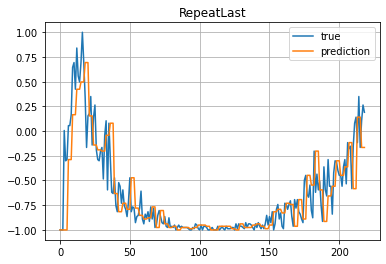

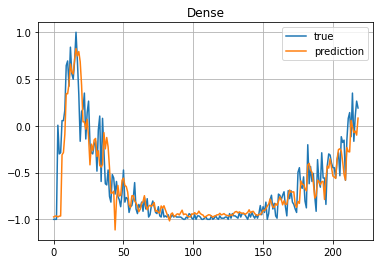

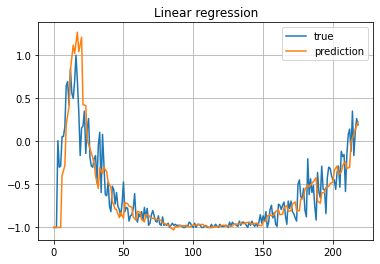

FR-O


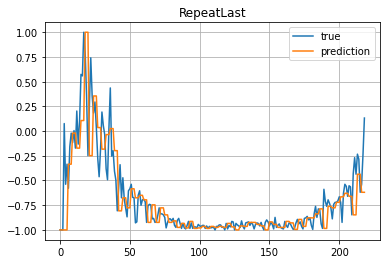

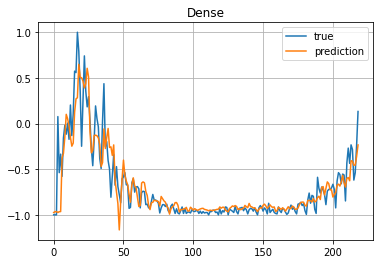

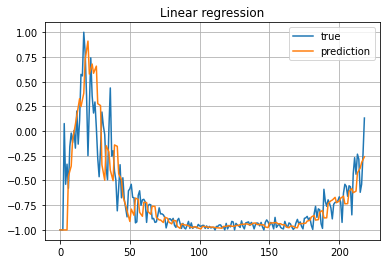

FR-I


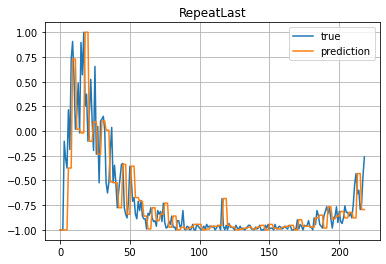

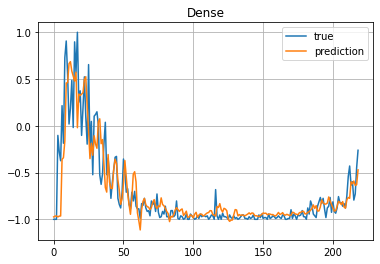

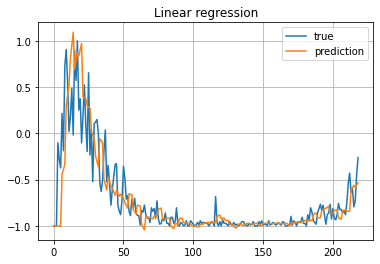

FR-L


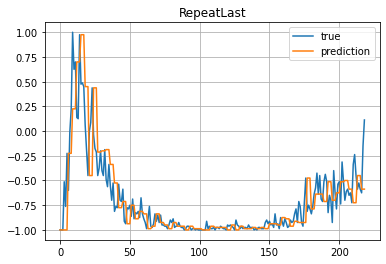

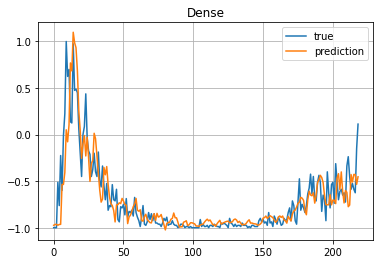

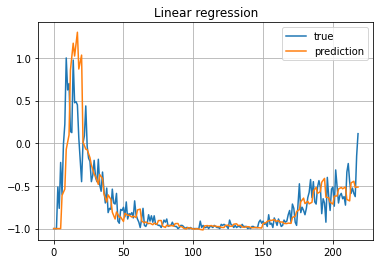

FR-H


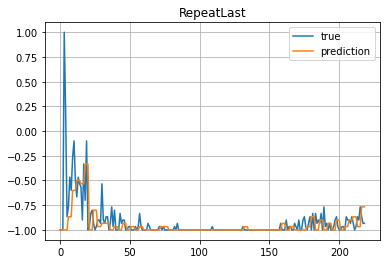

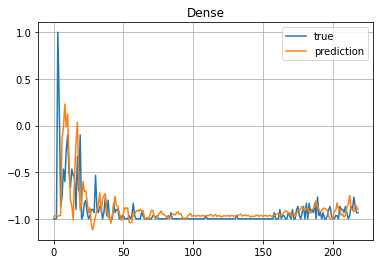

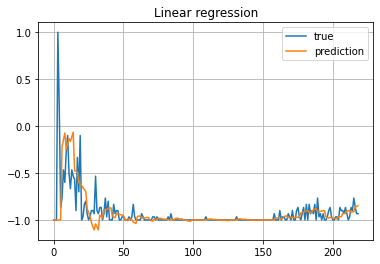

FR-E


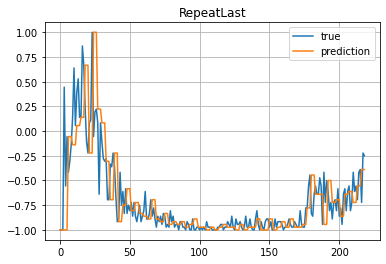

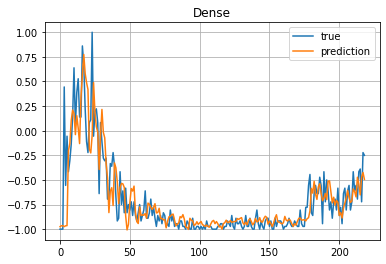

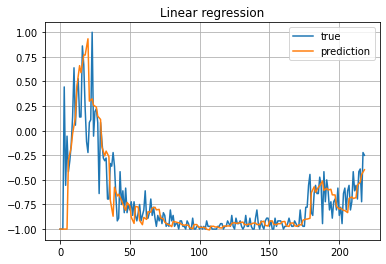

,MSE,MAE
Model,,
Dense,0.038785,0.111723
Linear regression,0.052022,0.120239
RepeatLast,0.057068,0.133965


In [43]:
error_set(all_models, valid_datapoints)

## Test

FR-D


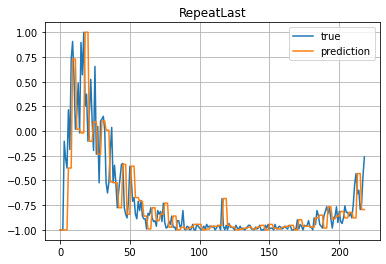

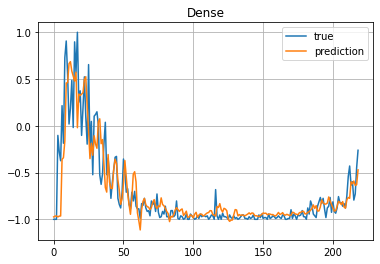

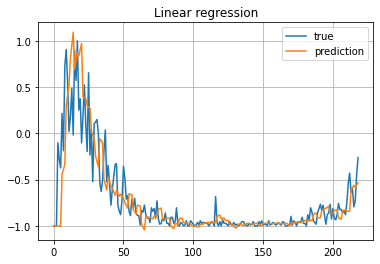

FR-T


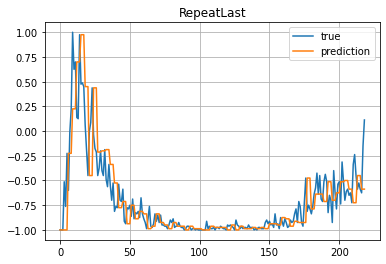

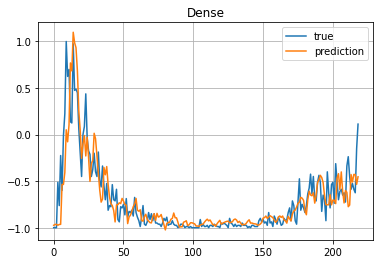

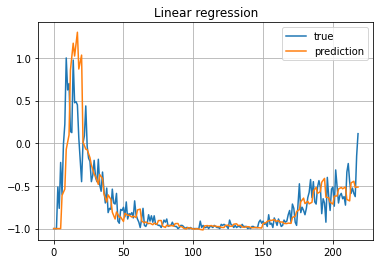

FR-R


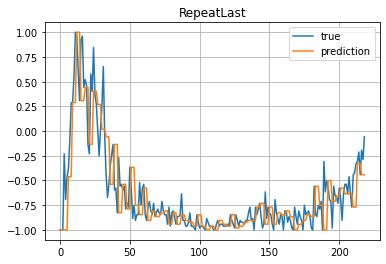

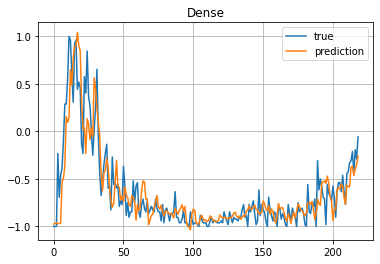

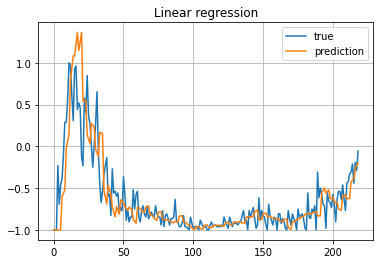

FR-U


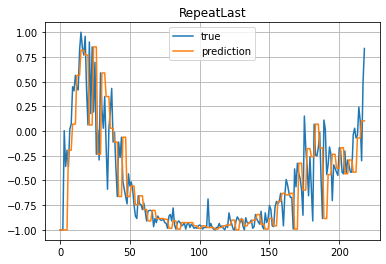

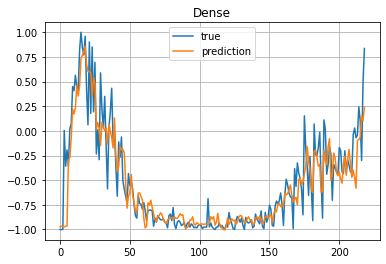

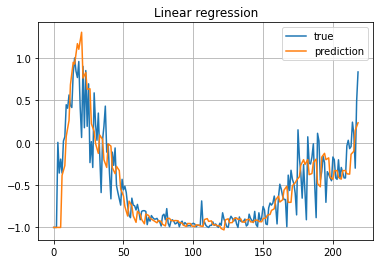

BE


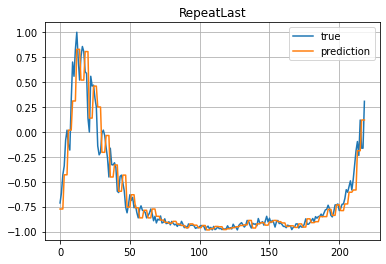

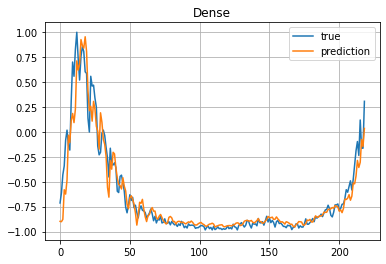

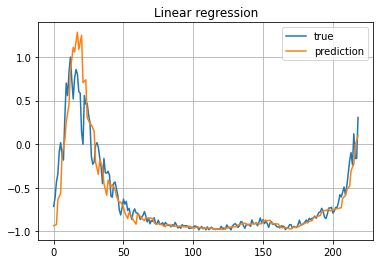

,MSE,MAE
Model,,
Dense,0.036529,0.116964
Linear regression,0.057896,0.137093
RepeatLast,0.058290,0.147460


In [44]:
error_set(all_models, test_datapoints)